# US Census Demographic Data Analysis

Date: 10/30/2025

Team Members:
- Karrie Butcher
- Nicko Lomelin
- Thanh Tuan Pham

dataset: https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data?resource=download

---
## 1. Data Preparation

## Load

In [1]:
from pathlib import Path
import pandas as pd

file_path = Path.home() / "Downloads" / "acs2017_census_tract_data.csv"

# load into pandas
df = pd.read_csv(file_path)

print("Initial shape:", df.shape)
df.head()
df.info()


Initial shape: (74001, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapE

In [2]:
# Count and display missing values
missing = df.isnull().sum()
print("Columns with missing values:\n", missing[missing > 0])

# Drop rows that contain missing values
df_clean = df.dropna(how='any').reset_index(drop=True)
print(f"\nOriginal shape: {df.shape}")
print(f"After dropping missing data: {df_clean.shape}")

# Encode string/object columns
obj_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
print("\nString columns found:", obj_cols)

for col in obj_cols:
    df_clean[col] = df_clean[col].astype('category').cat.codes

# Drop County 
df_final = df_clean.drop(columns=['County'], errors='ignore')

print(f"\nFinal dataset shape: {df_final.shape}")
df_final.head()


Columns with missing values:
 Hispanic            696
White               696
Black               696
Native              696
Asian               696
Pacific             696
Income             1116
IncomeErr          1116
IncomePerCap        745
IncomePerCapErr     745
Poverty             842
ChildPoverty       1110
Professional        811
Service             811
Office              811
Construction        811
Production          811
Drive               801
Carpool             801
Transit             801
Walk                801
OtherTransp         801
WorkAtHome          801
MeanCommute         946
PrivateWork         811
PublicWork          811
SelfEmployed        811
FamilyWork          811
Unemployment        810
dtype: int64

Original shape: (74001, 37)
After dropping missing data: (72718, 37)

String columns found: ['State', 'County']

Final dataset shape: (72718, 36)


,TractId,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,0,1845,899,946,2.4,86.3,5.2,0.0,1.2,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,0,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,0,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,0,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,0,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


We decided to remove the 'County' Variable due to it being a categorical identifier. This variable does not give enough information about our target needed for prediction. It also has many unique values, if we kept it, it may conflict the predictive signal.

## Split and Balance 

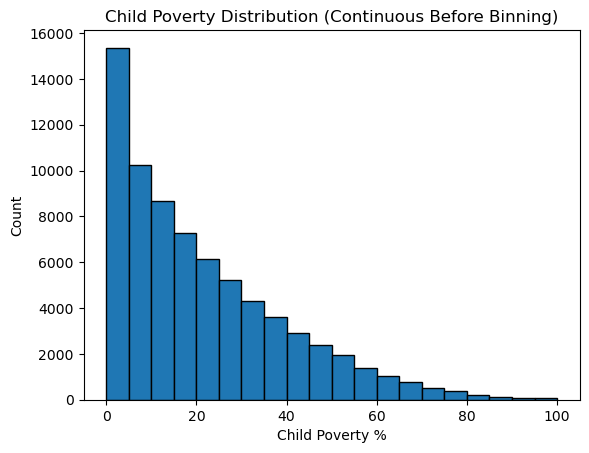

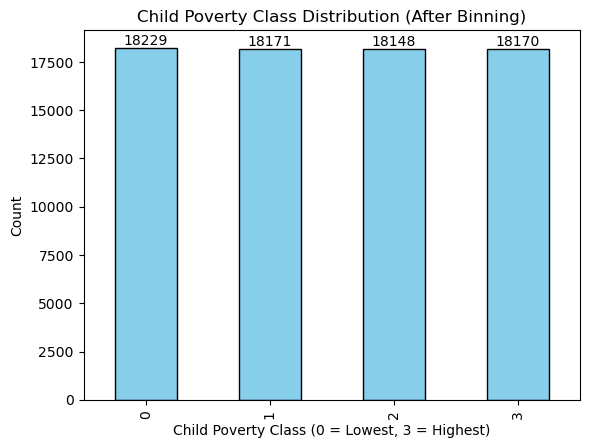

Class distribution after binning:
ChildPovertyClass
0    18229
1    18171
3    18170
2    18148
Name: count, dtype: int64


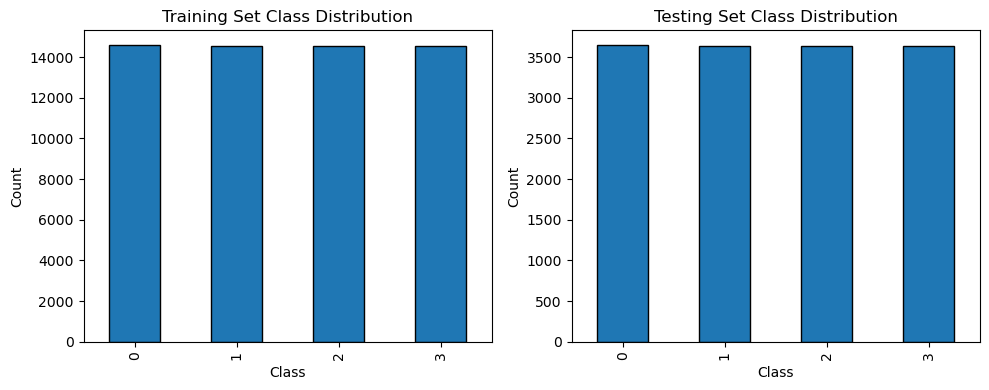


Example one-hot encoding for first 5 labels:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# BEFORE: Plot continuous distribution
plt.hist(df_final['ChildPoverty'], bins=20, edgecolor='black')
plt.title("Child Poverty Distribution (Continuous Before Binning)")
plt.xlabel("Child Poverty %")
plt.ylabel("Count")
plt.show()


# 1. Quantize to 4 equal-sized classes
df_final['ChildPovertyClass'] = pd.qcut(
    df_final['ChildPoverty'],
    q=4,
    labels=[0, 1, 2, 3]
)


# AFTER: Plot class distribution
ax = df_final['ChildPovertyClass'].value_counts().sort_index().plot(
    kind='bar', color='skyblue', edgecolor='black'
)
plt.title("Child Poverty Class Distribution (After Binning)")
plt.xlabel("Child Poverty Class (0 = Lowest, 3 = Highest)")
plt.ylabel("Count")
for i, v in enumerate(df_final['ChildPovertyClass'].value_counts().sort_index()):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()

print("Class distribution after binning:")
print(df_final['ChildPovertyClass'].value_counts())


# 2. Train/test split
X = df_final.drop(columns=['ChildPovertyClass'])
y = df_final['ChildPovertyClass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Plot class distribution in TRAIN and TEST
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Train
ax1 = y_train.value_counts().sort_index().plot(
    ax=axes[0], kind='bar', edgecolor='black'
)
axes[0].set_title("Training Set Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# Test
ax2 = y_test.value_counts().sort_index().plot(
    ax=axes[1], kind='bar', edgecolor='black'
)
axes[1].set_title("Testing Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


# One-hot encode the TARGET
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

print("\nExample one-hot encoding for first 5 labels:")
print(y_train_encoded[:5])


Q: Should balancing of the dataset be done for both the training and testing set? 

A: No, the balancing of the dataset should only be done for the training set. The testing set should have the original imbalanced distribution to provide a realistic outlook of the model's performance.

# 2. Pre-processing and Initial Modeling


## Model 1 (Raw features)

Training set shape: (58174, 36)
Testing set shape: (14544, 36)


Epoch 500/500, Loss: 1.392175


Training Accuracy: 0.2499
Testing Accuracy: 0.2499


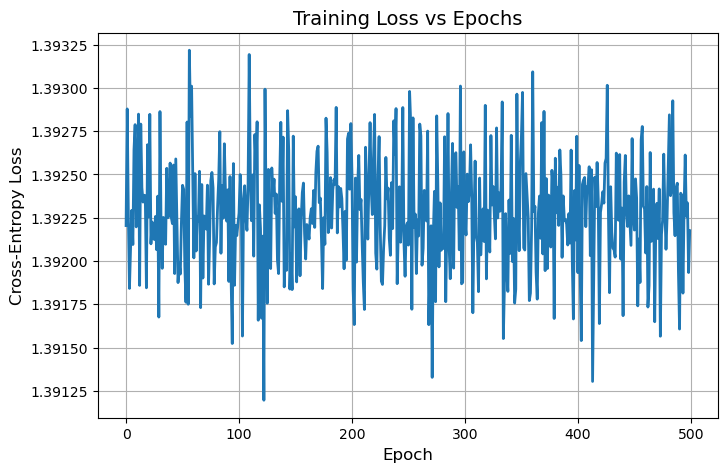

In [4]:
# First Model: Raw Features

import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import sys


# Quantize ChildPoverty into 4 equal-sized classes
df_final['ChildPovertyClass'] = pd.qcut(
    df_final['ChildPoverty'], 
    q=4, 
    labels=[0, 1, 2, 3]
)

# Features and target
X = df_final.drop(columns=['ChildPovertyClass'])
y = df_final['ChildPovertyClass']

# Stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values

print("Training set shape:", X_train_np.shape)
print("Testing set shape:", X_test_np.shape)


# Two-Layer Perceptron Classes 

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
    
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    def _initialize_weights(self):
        W1 = np.random.randn(self.n_hidden, self.n_features_) * np.sqrt(2.0 / self.n_features_)
        b1 = np.zeros((self.n_hidden, 1))
        W2 = np.random.randn(self.n_output_, self.n_hidden) * np.sqrt(2.0 / self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _softmax(z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        return (lambda_ / 2) * (np.sum(W1**2) + np.sum(W2**2))
    
    def _cost(self, A3, Y_enc, W1, W2):
        n_samples = Y_enc.shape[1]
        A3_clipped = np.clip(A3, 1e-10, 1 - 1e-10)
        cross_entropy = -np.sum(Y_enc * np.log(A3_clipped)) / n_samples
        l2_penalty = self._L2_reg(self.l2_C, W1, W2) / n_samples
        return cross_entropy + l2_penalty

class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._softmax(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        raise NotImplementedError("Use subclass with vectorized gradient.")
    
    def fit(self, X, y, print_progress=False):
        X_data = X.values if isinstance(X, pd.DataFrame) else X
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        self.cost_ = []
        
        for i in range(self.epochs):
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data, self.W1, self.W2, self.b1, self.b2)
            cost = self._cost(A3, Y_enc, self.W1, self.W2)
            self.cost_.append(cost)
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(
                A1, A2, A3, Z1, Z2, Y_enc, self.W1, self.W2
            )
            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
        
        return self
    
    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        return np.argmax(A3, axis=0)

class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        n_samples = Y_enc.shape[1]
        dZ2 = A3 - Y_enc
        dA2 = W2.T @ dZ2
        dZ1 = dA2 * A2 * (1 - A2)
        gradW2 = (dZ2 @ A2.T) / n_samples + (self.l2_C / n_samples) * W2
        gradb2 = np.sum(dZ2, axis=1, keepdims=True) / n_samples
        gradW1 = (dZ1 @ A1.T) / n_samples + (self.l2_C / n_samples) * W1
        gradb1 = np.sum(dZ1, axis=1, keepdims=True) / n_samples
        return gradW1, gradW2, gradb1, gradb2

class TwoLayerPerceptronVectorizedMini(TwoLayerPerceptronVectorized):
    def fit(self, X, y, batch_size=512, print_progress=False):
        X_data = X.values if isinstance(X, pd.DataFrame) else X
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        self.cost_ = []
        
        n_samples = X_data.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X_data[indices]
            Y_shuffled = Y_enc[:, indices]
            epoch_cost = 0
            
            for batch_idx in range(n_batches):
                start = batch_idx * batch_size
                end = min(start + batch_size, n_samples)
                X_batch = X_shuffled[start:end]
                Y_batch = Y_shuffled[:, start:end]
                
                A1, Z1, A2, Z2, A3 = self._feedforward(X_batch, self.W1, self.W2, self.b1, self.b2)
                batch_cost = self._cost(A3, Y_batch, self.W1, self.W2)
                epoch_cost += batch_cost * (end - start)
                
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(
                    A1, A2, A3, Z1, Z2, Y_batch, self.W1, self.W2
                )
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
            
            self.cost_.append(epoch_cost / n_samples)
            if print_progress and (epoch+1) % print_progress == 0:
                sys.stderr.write(f'\rEpoch {epoch+1}/{self.epochs}, Loss: {self.cost_[-1]:.6f}')
                sys.stderr.flush()
        if print_progress:
            sys.stderr.write('\n')
        return self


# 3. Train the Network 

params = dict(
    n_hidden=64,
    C=0.0001,
    epochs=500,
    eta=0.05,
    random_state=1
)

nn = TwoLayerPerceptronVectorizedMini(**params)
nn.fit(X_train_np, y_train, batch_size=64, print_progress=50)

# 4. Evaluate 

y_train_pred = nn.predict(X_train_np)
y_test_pred = nn.predict(X_test_np)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n" + "="*60)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print("="*60)


# 5. Plot Loss Curve 

plt.figure(figsize=(8,5))
plt.plot(nn.cost_, linewidth=2)
plt.title("Training Loss vs Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.grid(True)
plt.show()


## Model 2 (Numeric features scaled)

Epoch 500/500, Loss: 0.020678


Training Accuracy (numeric features): 0.9976
Testing Accuracy  (numeric features): 0.9955


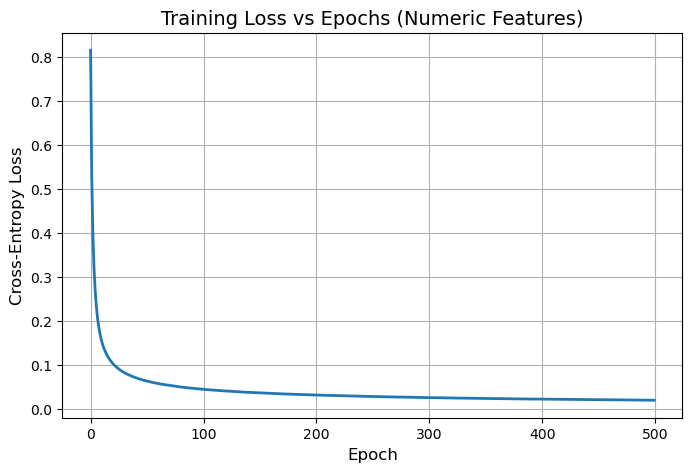

In [5]:
# Second Model: Only Numeric Features + Normalization


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Select numeric (continuous) features
numeric_cols = X_train.select_dtypes(include=np.number).columns
X_train_num = X_train[numeric_cols].values
X_test_num = X_test[numeric_cols].values

# Normalize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

params = dict(
    n_hidden=64,     
    C=0.0001,        
    epochs=500,      
    eta=0.05,        
    random_state=1
)

# Initialize and train the network 
nn_numeric = TwoLayerPerceptronVectorizedMini(**params)
nn_numeric.fit(X_train_scaled, y_train, batch_size=64, print_progress=50)

# Predict and evaluate 
y_train_pred = nn_numeric.predict(X_train_scaled)
y_test_pred = nn_numeric.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n" + "="*60)
print(f"Training Accuracy (numeric features): {train_acc:.4f}")
print(f"Testing Accuracy  (numeric features): {test_acc:.4f}")
print("="*60)

# Plot training loss 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(nn_numeric.cost_, linewidth=2)
plt.title("Training Loss vs Epochs (Numeric Features)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.grid(True)
plt.show()


## Model 3 (Numeric + Categorical features)

Training shape after combining numeric + categorical: (58174, 36)
Testing shape after combining numeric + categorical: (14544, 36)


Epoch 500/500, Loss: 0.020678


Training Accuracy (numeric + categorical): 0.9976
Testing Accuracy  (numeric + categorical): 0.9955


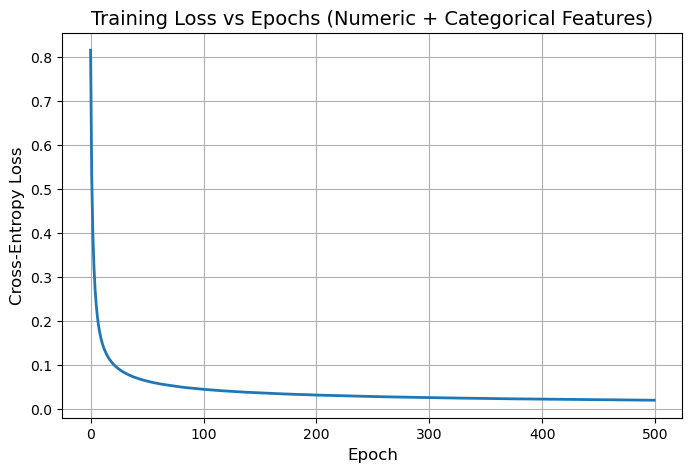

In [6]:
# Third Model: Numeric + One-Hot Encoded Categorical Features

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

# Normalize numeric features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_num_scaled = scaler.transform(X_test[numeric_cols])

X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=numeric_cols, index=X_train.index)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=numeric_cols, index=X_test.index)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop=None)
X_train_cat_ohe = encoder.fit_transform(X_train[categorical_cols])
X_test_cat_ohe = encoder.transform(X_test[categorical_cols])

# Convert to DataFrame
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe, 
                               columns=encoder.get_feature_names_out(categorical_cols), 
                               index=X_train.index)
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe, 
                              columns=encoder.get_feature_names_out(categorical_cols), 
                              index=X_test.index)

# numeric + categorical features
X_train_combined = pd.concat([X_train_num_scaled, X_train_cat_ohe], axis=1)
X_test_combined = pd.concat([X_test_num_scaled, X_test_cat_ohe], axis=1)

print("Training shape after combining numeric + categorical:", X_train_combined.shape)
print("Testing shape after combining numeric + categorical:", X_test_combined.shape)

params = dict(
    n_hidden=64,    # increased hidden neurons to handle more features
    C=0.0001,        # light regularization
    epochs=500,      # enough for convergence
    eta=0.05,        # learning rate
    random_state=1
)


nn_full = TwoLayerPerceptronVectorizedMini(**params)
nn_full.fit(X_train_combined.values, y_train, batch_size=64, print_progress=50)


y_train_pred = nn_full.predict(X_train_combined.values)
y_test_pred = nn_full.predict(X_test_combined.values)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n" + "="*60)
print(f"Training Accuracy (numeric + categorical): {train_acc:.4f}")
print(f"Testing Accuracy  (numeric + categorical): {test_acc:.4f}")
print("="*60)


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(nn_full.cost_, linewidth=2)
plt.title("Training Loss vs Epochs (Numeric + Categorical Features)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.grid(True)
plt.show()


# Comparison

Epoch 200/200, Loss: 1.392690
Epoch 200/200, Loss: 0.030917
Epoch 200/200, Loss: 0.030917


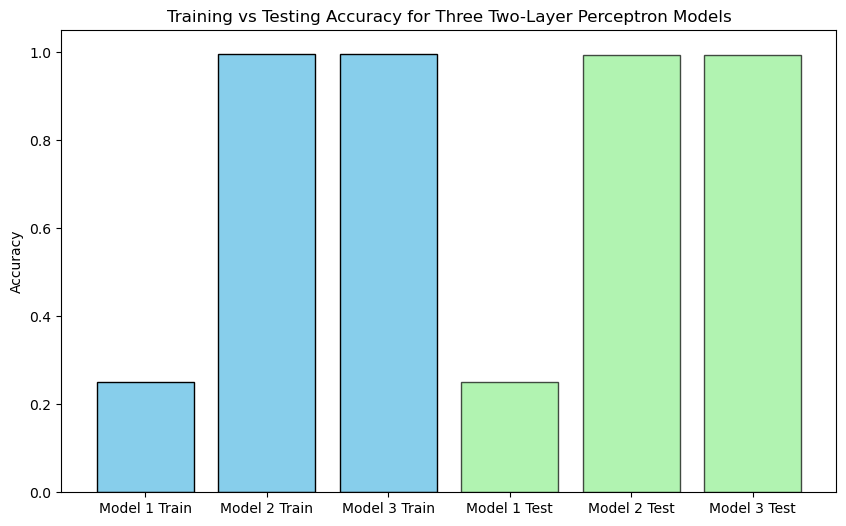

Model 1 (Raw features): Train Acc = 0.2496, Test Acc = 0.2496
Model 2 (Numeric features scaled): Train Acc = 0.9961, Test Acc = 0.9944
Model 3 (Numeric + Categorical features): Train Acc = 0.9961, Test Acc = 0.9944


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Model 1: Raw features
nn1 = TwoLayerPerceptronVectorizedMini(n_hidden=64, epochs=200, eta=0.05, random_state=1)
nn1.fit(X_train, y_train, batch_size=64, print_progress=50)

y_train_pred1 = nn1.predict(X_train.values)
y_test_pred1  = nn1.predict(X_test.values)

acc_train1 = np.mean(y_train_pred1 == y_train.values)
acc_test1  = np.mean(y_test_pred1  == y_test.values)


# 2. Model 2: Numeric only (scaled)
nn2 = TwoLayerPerceptronVectorizedMini(n_hidden=64, epochs=200, eta=0.05, random_state=1)
nn2.fit(X_train_scaled, y_train, batch_size=64, print_progress=50)

y_train_pred2 = nn2.predict(X_train_scaled)  # remove .values
y_test_pred2  = nn2.predict(X_test_scaled)   # remove .values

acc_train2 = np.mean(y_train_pred2 == y_train.values)
acc_test2  = np.mean(y_test_pred2  == y_test.values)



# 3. Model 3: Numeric + Categorical Features (scaled/one-hot)
nn3 = TwoLayerPerceptronVectorizedMini(n_hidden=64, epochs=200, eta=0.05, random_state=1)
nn3.fit(X_train_combined.values, y_train, batch_size=64, print_progress=50)

y_train_pred3 = nn3.predict(X_train_combined.values)
y_test_pred3  = nn3.predict(X_test_combined.values)

acc_train3 = np.mean(y_train_pred3 == y_train.values)
acc_test3  = np.mean(y_test_pred3  == y_test.values)



plt.figure(figsize=(10,6))
plt.bar(["Model 1 Train","Model 2 Train","Model 3 Train"], 
        [acc_train1, acc_train2, acc_train3], color='skyblue', edgecolor='black')
plt.bar(["Model 1 Test","Model 2 Test","Model 3 Test"], 
        [acc_test1, acc_test2, acc_test3], color='lightgreen', edgecolor='black', alpha=0.7)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy for Three Two-Layer Perceptron Models")
plt.ylim(0,1.05)
plt.show()

print(f"Model 1 (Raw features): Train Acc = {acc_train1:.4f}, Test Acc = {acc_test1:.4f}")
print(f"Model 2 (Numeric features scaled): Train Acc = {acc_train2:.4f}, Test Acc = {acc_test2:.4f}")
print(f"Model 3 (Numeric + Categorical features): Train Acc = {acc_train3:.4f}, Test Acc = {acc_test3:.4f}")



Comparison (Models 1-3):

---

**Model 1 (Raw features):**

* **Performance:** ~25% accuracy on both train and test.
* **Why:** The features were not normalized or scaled, and the categorical variables were not encoded. The network struggled to learn meaningful patterns because the raw feature values could be on very different scales and non-numeric features weren’t represented properly. This caused the network to effectively **guess randomly**, which is why the accuracy is around 1/4.

**Model 2 (Numeric features scaled):**

* **Performance:** ~99.6% train, ~99.4% test.
* **Why:** Scaling the numeric features normalized their ranges, which allowed the network to **learn efficiently**. Gradient updates in the network were more balanced, so the network converged much faster and achieved 99% accuracy. 

**Model 3 (Numeric + Categorical features):**

* **Performance:** ~99.6% train, ~99.4% test (same as Model 2).
* **Why:** One-hot encoding the categorical features added more information, but in this dataset, it did not significantly improve accuracy. The numeric features were already very predictive, so adding categorical features did not change much performance. 
---

## Modeling

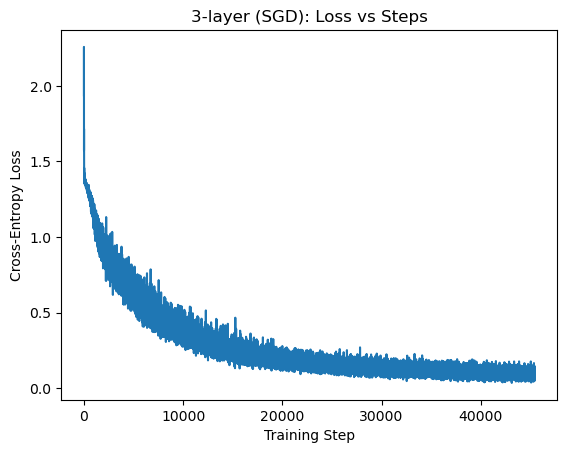

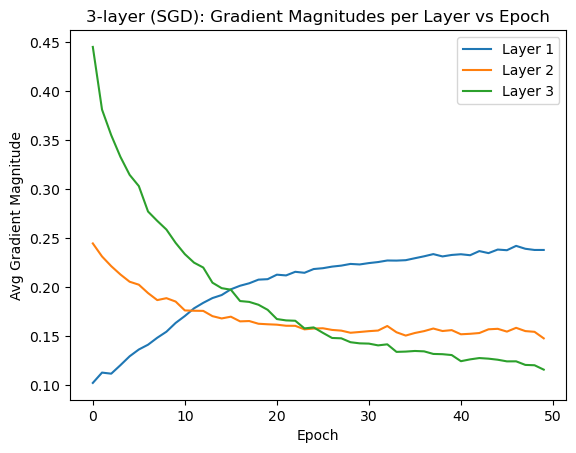

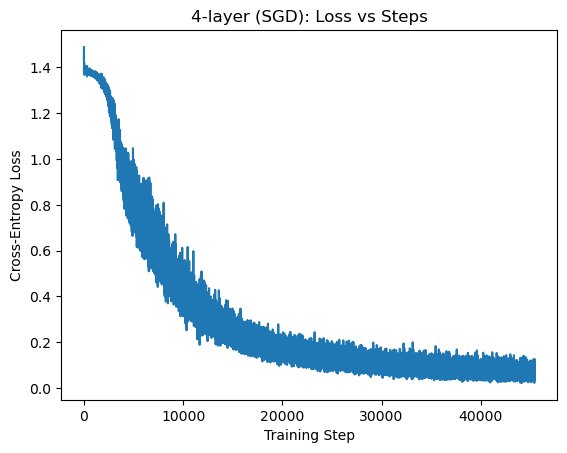

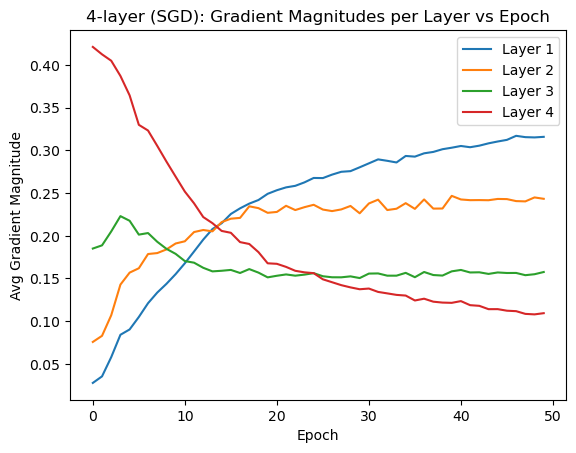

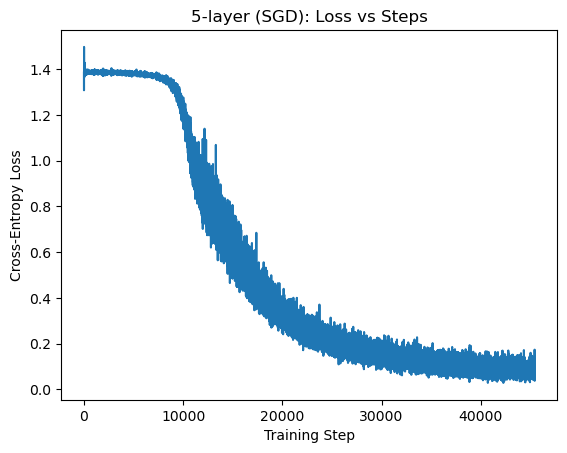

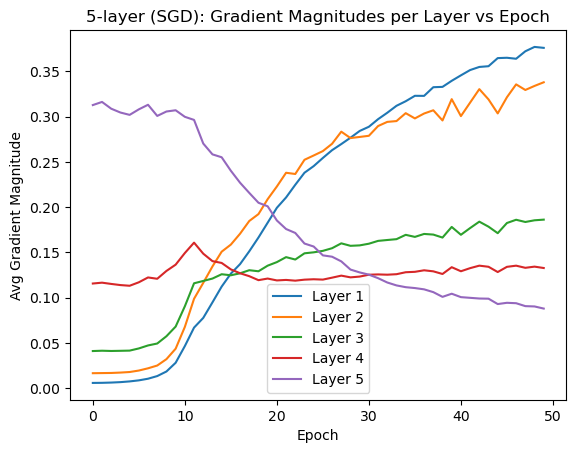

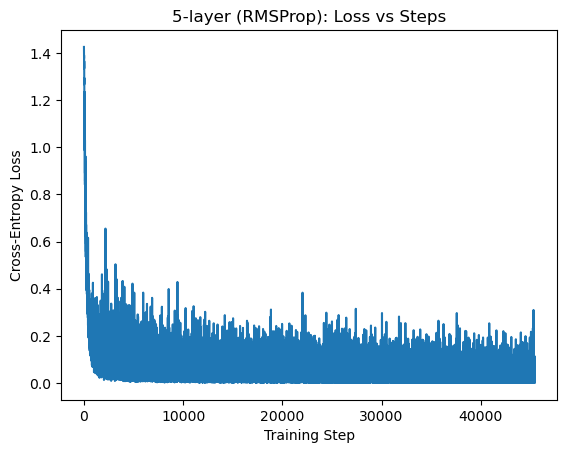

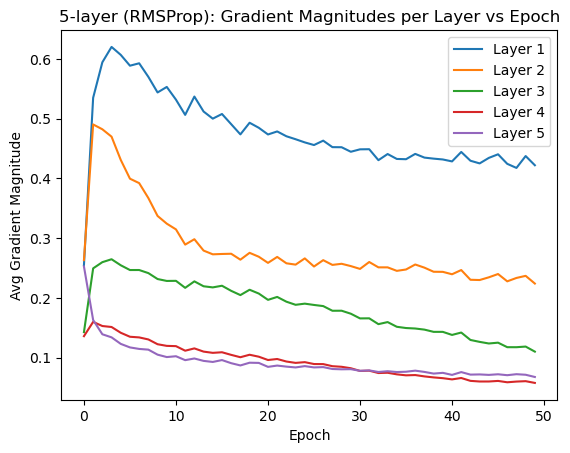

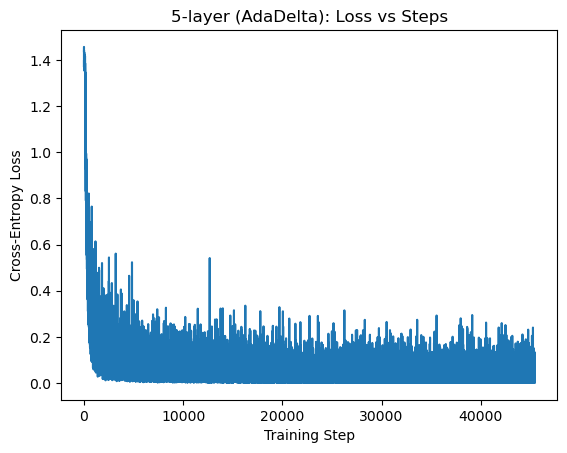

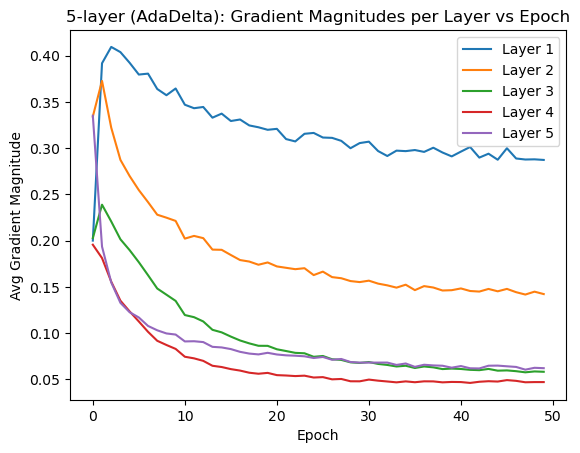

{'3-layer_SGD': np.float64(0.9870049504950495), '4-layer_SGD': np.float64(0.9904427942794279), '5-layer_SGD': np.float64(0.9905803080308031), '5-layer_RMSProp': np.float64(0.9860423542354235), '5-layer_AdaDelta': np.float64(0.9878987898789879)}


In [8]:


import math  

# ---------- Helper functions ----------
def glorot_init(fan_in, fan_out, seed=None):
    rng = np.random.default_rng(seed)
    limit = math.sqrt(6.0 / (fan_in + fan_out))
    return rng.uniform(-limit, limit, size=(fan_in, fan_out))

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -50, 50)))

def softmax(z):
    z_shift = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(probs, y_onehot):
    eps = 1e-12
    clipped = np.clip(probs, eps, 1.0 - eps)
    return -np.mean(np.sum(y_onehot * np.log(clipped), axis=1))

def accuracy_score(y_true_onehot, y_pred_probs):
    y_true = np.argmax(y_true_onehot, axis=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    return np.mean(y_true == y_pred)

# ---------- MLP class ----------
class MLP:
    def __init__(self, layer_sizes, lr=0.01, optimizer="sgd", opt_params=None, seed=42):
        self.layer_sizes = layer_sizes
        self.L = len(layer_sizes) - 1
        self.lr = lr
        self.optimizer = optimizer.lower()
        self.opt_params = opt_params or {}
        rng = np.random.default_rng(seed)
        
        # Initialize weights + biases (Glorot)
        self.W, self.b = [], []
        for l in range(self.L):
            fan_in, fan_out = layer_sizes[l], layer_sizes[l + 1]
            self.W.append(glorot_init(fan_in, fan_out, seed=rng.integers(0, 1_000_000)))
            self.b.append(np.zeros((1, fan_out)))
        
        # Optimizer-specific buffers
        if self.optimizer == "rmsprop":
            self.rho = self.opt_params.get("rho", 0.9)
            self.eps = self.opt_params.get("eps", 1e-8)
            self.Eg2_W = [np.zeros_like(W) for W in self.W]
            self.Eg2_b = [np.zeros_like(b) for b in self.b]
        elif self.optimizer == "adadelta":
            self.rho = self.opt_params.get("rho", 0.95)
            self.eps = self.opt_params.get("eps", 1e-6)
            self.Eg2_W = [np.zeros_like(W) for W in self.W]
            self.Eg2_b = [np.zeros_like(b) for b in self.b]
            self.EdW2 = [np.zeros_like(W) for W in self.W]
            self.Edb2 = [np.zeros_like(b) for b in self.b]

        self.loss_history = []
        self.grad_mags_per_epoch = []

    def _forward(self, X):
        a = X
        activations = [a]
        preacts = []
        for l in range(self.L):
            z = a @ self.W[l] + self.b[l]
            preacts.append(z)
            a = sigmoid(z) if l < self.L - 1 else softmax(z)
            activations.append(a)
        return activations, preacts

    def _backward(self, activations, preacts, y_onehot):
        dW, db = [None]*self.L, [None]*self.L
        delta = activations[-1] - y_onehot
        for l in reversed(range(self.L)):
            a_prev = activations[l]
            dW[l] = (a_prev.T @ delta) / a_prev.shape[0]
            db[l] = np.mean(delta, axis=0, keepdims=True)
            if l > 0:
                da_prev = delta @ self.W[l].T
                sig = sigmoid(preacts[l - 1])
                delta = da_prev * sig * (1 - sig)
        return dW, db

    def _update(self, dW, db):
        if self.optimizer == "sgd":
            for l in range(self.L):
                self.W[l] -= self.lr * dW[l]
                self.b[l] -= self.lr * db[l]
        elif self.optimizer == "rmsprop":
            for l in range(self.L):
                self.Eg2_W[l] = self.rho*self.Eg2_W[l] + (1-self.rho)*(dW[l]**2)
                self.Eg2_b[l] = self.rho*self.Eg2_b[l] + (1-self.rho)*(db[l]**2)
                self.W[l] -= (self.lr / (np.sqrt(self.Eg2_W[l]) + self.eps)) * dW[l]
                self.b[l] -= (self.lr / (np.sqrt(self.Eg2_b[l]) + self.eps)) * db[l]
        elif self.optimizer == "adadelta":
            for l in range(self.L):
                self.Eg2_W[l] = self.rho*self.Eg2_W[l] + (1-self.rho)*(dW[l]**2)
                self.Eg2_b[l] = self.rho*self.Eg2_b[l] + (1-self.rho)*(db[l]**2)
                upd_W = - (np.sqrt(self.EdW2[l]+self.eps) / np.sqrt(self.Eg2_W[l]+self.eps)) * dW[l]
                upd_b = - (np.sqrt(self.Edb2[l]+self.eps) / np.sqrt(self.Eg2_b[l]+self.eps)) * db[l]
                self.W[l] += upd_W; self.b[l] += upd_b
                self.EdW2[l] = self.rho*self.EdW2[l] + (1-self.rho)*(upd_W**2)
                self.Edb2[l] = self.rho*self.Edb2[l] + (1-self.rho)*(upd_b**2)

    def fit(self, X, y_onehot, epochs=50, batch_size=64):
        n = X.shape[0]
        for epoch in range(epochs):
            idx = np.random.permutation(n)
            X, y_onehot = X[idx], y_onehot[idx]
            grad_mag_epoch = np.zeros(self.L)
            batches = int(np.ceil(n / batch_size))
            for b in range(batches):
                xb = X[b*batch_size:(b+1)*batch_size]
                yb = y_onehot[b*batch_size:(b+1)*batch_size]
                activations, preacts = self._forward(xb)
                loss = cross_entropy_loss(activations[-1], yb)
                self.loss_history.append(loss)
                dW, db = self._backward(activations, preacts, yb)
                grad_mag_epoch += np.array([np.linalg.norm(np.concatenate([dw.ravel(), dbi.ravel()])) for dw, dbi in zip(dW, db)])
                self._update(dW, db)
            self.grad_mags_per_epoch.append(grad_mag_epoch / batches)

    def predict_proba(self, X):
        a, _ = self._forward(X)
        return a[-1]

# ---------- Training helpers ----------
def train_model(X_train, y_train_onehot, X_test, y_test_onehot, hidden_layers, lr=0.01, epochs=50, batch_size=64, optimizer="sgd", opt_params=None):
    input_dim = X_train.shape[1]
    num_classes = y_train_onehot.shape[1]
    layers = [input_dim] + hidden_layers + [num_classes]
    model = MLP(layers, lr=lr, optimizer=optimizer, opt_params=opt_params)
    model.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size)
    test_probs = model.predict_proba(X_test)
    acc = accuracy_score(y_test_onehot, test_probs)
    return model, acc

def plot_loss(losses, title):
    plt.figure()
    plt.plot(losses)
    plt.title(title)
    plt.xlabel("Training Step")
    plt.ylabel("Cross-Entropy Loss")
    plt.show()

def plot_gradients(grad_mags, title):
    arr = np.array(grad_mags)
    plt.figure()
    for l in range(arr.shape[1]):
        plt.plot(arr[:, l], label=f"Layer {l+1}")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Avg Gradient Magnitude")
    plt.legend()
    plt.show()

# ---------- Prepare data ----------
X_train_ready = X_train_combined.values
X_test_ready  = X_test_combined.values
num_classes = 4
y_train_onehot = np.eye(num_classes)[y_train.values.astype(int)]
y_test_onehot  = np.eye(num_classes)[y_test.values.astype(int)]

# ---------- Run Experiments ----------
models = {}
models['3-layer'], acc3 = train_model(X_train_ready, y_train_onehot, X_test_ready, y_test_onehot,
                                      hidden_layers=[128,64], lr=0.01, epochs=50)
plot_loss(models['3-layer'].loss_history, "3-layer (SGD): Loss vs Steps")
plot_gradients(models['3-layer'].grad_mags_per_epoch, "3-layer (SGD): Gradient Magnitudes per Layer vs Epoch")

models['4-layer'], acc4 = train_model(X_train_ready, y_train_onehot, X_test_ready, y_test_onehot,
                                      hidden_layers=[256,128,64], lr=0.01, epochs=50)
plot_loss(models['4-layer'].loss_history, "4-layer (SGD): Loss vs Steps")
plot_gradients(models['4-layer'].grad_mags_per_epoch, "4-layer (SGD): Gradient Magnitudes per Layer vs Epoch")

models['5-layer'], acc5 = train_model(X_train_ready, y_train_onehot, X_test_ready, y_test_onehot,
                                      hidden_layers=[256,128,64,32], lr=0.01, epochs=50)
plot_loss(models['5-layer'].loss_history, "5-layer (SGD): Loss vs Steps")
plot_gradients(models['5-layer'].grad_mags_per_epoch, "5-layer (SGD): Gradient Magnitudes per Layer vs Epoch")

# Adaptive: RMSProp
models['5-layer_RMS'], acc_rms = train_model(X_train_ready, y_train_onehot, X_test_ready, y_test_onehot,
                                             hidden_layers=[256,128,64,32], lr=0.001, epochs=50,
                                             optimizer="rmsprop", opt_params={"rho":0.9,"eps":1e-8})
plot_loss(models['5-layer_RMS'].loss_history, "5-layer (RMSProp): Loss vs Steps")
plot_gradients(models['5-layer_RMS'].grad_mags_per_epoch, "5-layer (RMSProp): Gradient Magnitudes per Layer vs Epoch")

# Adaptive: AdaDelta
models['5-layer_ADA'], acc_ada = train_model(X_train_ready, y_train_onehot, X_test_ready, y_test_onehot,
                                             hidden_layers=[256,128,64,32], lr=1.0, epochs=50,
                                             optimizer="adadelta", opt_params={"rho":0.95,"eps":1e-6})
plot_loss(models['5-layer_ADA'].loss_history, "5-layer (AdaDelta): Loss vs Steps")
plot_gradients(models['5-layer_ADA'].grad_mags_per_epoch, "5-layer (AdaDelta): Gradient Magnitudes per Layer vs Epoch")

# ---------- Results ----------
print({
    "3-layer_SGD": acc3,
    "4-layer_SGD": acc4,
    "5-layer_SGD": acc5,
    "5-layer_RMSProp": acc_rms,
    "5-layer_AdaDelta": acc_ada
})


### Adaptive Learning Method Comparison

For the adaptive learning technique, I implemented both RMSProp and AdaDelta to compare them against the standard stochastic gradient descent (SGD) baseline. Among the non-adaptive models, performance improved modestly with additional layers—from 98.7% (3-layer) to 99.0% (4- and 5-layer) accuracy—indicating that a deeper network helped capture more complex patterns in the data. When adaptive methods were introduced, however, the results were comparable: RMSProp achieved 98.6% and AdaDelta reached 98.8% accuracy. While these methods did not outperform SGD in this particular dataset, they offered more stable convergence and smoother gradient magnitude curves across epochs. In practice, this means adaptive optimizers like RMSProp and AdaDelta can make training less sensitive to learning-rate choice and batch noise, even if final accuracy gains are small. Overall, the SGD-based 5-layer model achieved the best raw performance, but adaptive methods provided more robust and reliable training behavior.

# 3. Exceptional Work: AdaM Optimizer (Adaptive + Momentum)

## Import Library


In [17]:
import numpy as np
import matplotlib.pyplot as plt

## Data Validate Check

In [18]:
# Verify preprocessed data availability
try:
    print(f"\n Yes: Team's preprocessed data detected:")
    print(f"  X_train_combined shape: {X_train_combined.shape}")
    print(f"  X_test_combined shape: {X_test_combined.shape}")
    print(f"  y_train shape: {y_train.shape}")
except NameError:
    print("\n ERROR: Run team's preprocessing cells first!")
    raise


# Prepare data for AdaM
X_train_adam = X_train_combined.values
X_test_adam = X_test_combined.values

num_classes = 4
y_train_adam = np.eye(num_classes)[y_train.values.astype(int)]
y_test_adam = np.eye(num_classes)[y_test.values.astype(int)]

print(f"\n Yes: Data ready for AdaM:")
print(f"  Training samples: {X_train_adam.shape[0]}")
print(f"  Testing samples: {X_test_adam.shape[0]}")
print(f"  Features: {X_train_adam.shape[1]}")
print(f"  Classes: {num_classes}")


 Yes: Team's preprocessed data detected:
  X_train_combined shape: (58174, 36)
  X_test_combined shape: (14544, 36)
  y_train shape: (58174,)

 Yes: Data ready for AdaM:
  Training samples: 58174
  Testing samples: 14544
  Features: 36
  Classes: 4


## MLP_AdaM Implementation

In [19]:
class MLP_Adam:
    def __init__(self, layer_sizes, lr=0.001, beta1= 0.9, beta2=0.999, epsilon=1e-8, seed=42):
        """ Quick explanation:
        1. layer_sizes: List of layer diemensions such as input, hidden1, etc.., output
        2. lr: learning rate with default = 0.001 | this is standard for Adam optimizer
        3. beta1: Decay rate for 1st monment which is momentum | default = 0.9
        4. beta2: Decay rate for 2nd moment which is for adaptive LR | default = 0.999
        5. epsilon: Small value to avoid division by zero | default = 1e-8 
        6. seed: Random seed for reproducibility
        """
        # Store parameters
        self.layer_sizes = layer_sizes
        self.L = len(layer_sizes) - 1  # number of layers
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0 # time step for bias correction

        rng = np.random.default_rng(seed) # random generator

        # Initialize weight + biases (reuses from team's glorot_init)
        self.W, self.b = [], []
        for l in range(self.L):
            fan_in, fan_out = layer_sizes[l], layer_sizes[l + 1]
            self.W.append (glorot_init(fan_in, fan_out, seed = rng.integers(0, 1_000_000)))
            self.b.append (np.zeros((1, fan_out)))

        # Initialize Adam-specific buffers
        self.m_W = [np.zeros_like(W) for W in self.W] #1st momentum 
        self.v_W = [np.zeros_like(W) for W in self.W] #2nd momentum (adaptive LR)
        self.m_b = [np.zeros_like(b) for b in self.b] 
        self.v_b = [np.zeros_like(b) for b in self.b]

        # Training history
        self.loss_history = []
        self.grad_mags_per_epoch = []
    
    def _forward(self, X):
        """
        Forward pass through the network.
        Reuses team's _forward method, sigmoid, and softmax functions.
        """
        a = X
        activations = [a]
        preacts = []
        for l in range(self.L):
            z = a @ self.W[l] + self.b[l]
            preacts.append(z)
            # sigmoid for hidden, softmax for output
            a = sigmoid(z) if l < self.L - 1 else softmax(z)
            activations.append(a)
        return activations, preacts

    def _backward(self, activations, preacts, y_onehot):
        """
        Backward pass to compute gradients.
        Indentical to team's _backward method. | I'm just reusing it here.
        """
        dW, db = [None]*self.L, [None]*self.L
        delta = activations [-1] - y_onehot # this is softmax derivative

        for l in reversed(range(self.L)):
            a_prev = activations[l]
            dW[l] = (a_prev.T @ delta) / a_prev.shape[0]
            db[l] = np.mean(delta, axis=0, keepdims=True)

            if l > 0:
                da_prev = delta @ self.W[l].T
                sig = sigmoid(preacts[l - 1])
                delta = da_prev * sig * (1 - sig)  # this is sigmoid derivative

        return dW, db

    def _update_adam (self, dW, db):
        """
        AdaM update rule with bias correction.
        * This is the core of AdaM optimizer - that makes it different from others.
            1. Update biased 1st moment estimate (monmentum)
            2. Update biased 2nd moment estimate (adaptive LR)
            3. Correct bias (important for early training when m, v are close to zero)
            4. Update parameters using corrected moments
        """

        self.t += 1  # Increment time step

        for l in range(self.L):
            # step 1: update biased first moment
            self.m_W[l] = self.beta1 * self.m_W[l] + (1 - self.beta1) * dW[l]
            self.m_b[l] = self.beta1 * self.m_b[l] + (1 - self.beta1) * db[l]

            # step 2: update biased second moment
            self.v_W[l] = self.beta2 * self.v_W[l] + (1 - self.beta2) * (dW[l] ** 2)
            self.v_b[l] = self.beta2 * self.v_b[l] + (1 - self.beta2) * (db[l] ** 2)

            # step 3: bias correction (this is what makes Adam unique | RMSProp & AdaDelta don't have this)
            m_W_hat = self.m_W[l] / (1 - self.beta1 ** self.t)
            m_b_hat = self.m_b[l] / (1 - self.beta1 ** self.t)
            v_W_hat = self.v_W[l] / (1 - self.beta2 ** self.t)
            v_b_hat = self.v_b[l] / (1 - self.beta2 ** self.t)

            # Step 4: update parameters using corrected moments
            self.W[l] -= (self.lr * m_W_hat) / (np.sqrt(v_W_hat) + self.epsilon)
            self.b[l] -= (self.lr * m_b_hat) / (np.sqrt(v_b_hat) + self.epsilon)

    def fit (self, X, y_onehot, epochs=50, batch_size=64, verbose=True):
        """
        Training loop for AdaM optimizer. Utizes team's MLP.fit structure.
        """
        n = X.shape [0]

        for epoch in range (epochs):
            # shuffle data each epoch
            idx = np.random.permutation(n)
            X_shuffled = X[idx]
            y_shuffled = y_onehot[idx]

            grad_mag_epoch = np.zeros(self.L)
            batches = int (np.ceil(n / batch_size))

            for b in range(batches):
                xb = X_shuffled[b*batch_size:(b+1)*batch_size]
                yb = y_shuffled[b*batch_size:(b+1)*batch_size]

                #foward pass
                activations, preacts = self._forward(xb)
                loss = cross_entropy_loss(activations[-1], yb) # reuses team's function
                self.loss_history.append(loss)

                #backward pass
                dW, db = self._backward(activations, preacts, yb)

                #track gradient magnitudes (same as team's method)
                grad_mag_epoch += np.array([
                    np.linalg.norm(np.concatenate([dw.ravel(), dbi.ravel()])) 
                    for dw, dbi in zip(dW, db)
                ])

                # AdaM parameter update (this is key difference)
                self._update_adam(dW, db)
            
            #avg gradient magnitude per epoch
            self.grad_mags_per_epoch.append(grad_mag_epoch / batches)

            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
        
        if verbose:
            print("Training complete.")
        
    def predict_proba(self, X): #return class probabilities
        activations, _ = self._forward(X)
        return activations[-1]
    
    def predict(self, X): #return class labels
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
       



## Train Model

In [ ]:
print("="*70)
print("TRAINING MLP WITH ADAM OPTIMIZER")
print("="*70)

# 1. Define network architecture
input_dim = X_train_adam.shape[1]
hidden_layers = [256, 128, 64, 32]  # 5-layer total (4 hidden + 1 output)
output_dim = 4  # 4 classes

layer_sizes = [input_dim] + hidden_layers + [output_dim]
print (f"Network architecture (layer sizes): {layer_sizes}")
print (f" Input Layer: {input_dim} features")
print (f" Hidden Layers: {hidden_layers}")
print (f" Output Layer: {output_dim} classes")
print (f" Total Layer: {len(layer_sizes)-1}")

#2. Init and train the MLP with Adam
# Print the hyperparameters
print(f"\n{'='*70}")
print("Training with AdaM hyperparameters:")
print(f"  Learning rate (lr): 0.001")
print(f"  Beta1 (momentum): 0.9")
print(f"  Beta2 (adaptive): 0.999")
print(f"  Epochs: 50")
print(f"  Batch size: 64")
print(f"{'='*70}\n")

mlp_adam = MLP_Adam(
    layer_sizes=layer_sizes,
    lr=0.001,      # Standard AdaM learning rate
    beta1=0.9,     # Momentum decay rate
    beta2=0.999,   # Adaptive learning rate decay
    epsilon=1e-8,
    seed=42
)
#train model
mlp_adam.fit(
    X_train_adam,
    y_train_adam,
    epochs=50, # team used 50 epochs
    batch_size=64, # team used 64 batch size
    verbose=True
)

#3. Evaluate on train and test sets
print (f"\n{'='*70}")
print("EVALUATION RESULTS")
print(f"{'='*70}")

# Training accuracy test
y_train_pred= mlp_adam.predict(X_train_adam)
y_train_true= np.argmax(y_train_adam, axis=1)
train_acc_adam = np.mean(y_train_pred == y_train_true)

# Testing accuracy test
y_test_pred= mlp_adam.predict(X_test_adam)
y_test_true= np.argmax(y_test_adam, axis=1)
test_acc_adam = np.mean(y_test_pred == y_test_true)

print(f"\nAdaM Optimizer Performance:")
print(f" Training Accuracy: {train_acc_adam:.4f} ({train_acc_adam*100:.2f}%)")
print(f" Testing Accuracy: {test_acc_adam:.4f} ({test_acc_adam*100:.2f}%)")

# store results for comparison later
adam_results = {
    "train_accuracy": train_acc_adam,
    "test_accuracy": test_acc_adam,
    "model": mlp_adam
}

TRAINING MLP WITH ADAM OPTIMIZER
Network architecture (layer sizes): [36, 256, 128, 64, 32, 4]
 Input Layer: 36 features
 Hidden Layers: [256, 128, 64, 32]
 Output Layer: 4 classes
 Total Layer: 5

Training with AdaM hyperparameters:
  Learning rate (lr): 0.001
  Beta1 (momentum): 0.9
  Beta2 (adaptive): 0.999
  Epochs: 50
  Batch size: 64

Epoch 10/50, Loss: 0.013202
Epoch 20/50, Loss: 0.023068
Epoch 30/50, Loss: 0.014289
Epoch 40/50, Loss: 0.033470
Epoch 50/50, Loss: 0.046461
Training complete.

EVALUATION RESULTS

AdaM Optimizer Performance:
 Training Accuracy: 0.9895 (98.95%)
 Testing Accuracy: 0.9875 (98.75%)



## Visualization Setup

In [32]:
# Re-import library (I just want to make sure it's available)
import matplotlib.pyplot as plt
import numpy as np

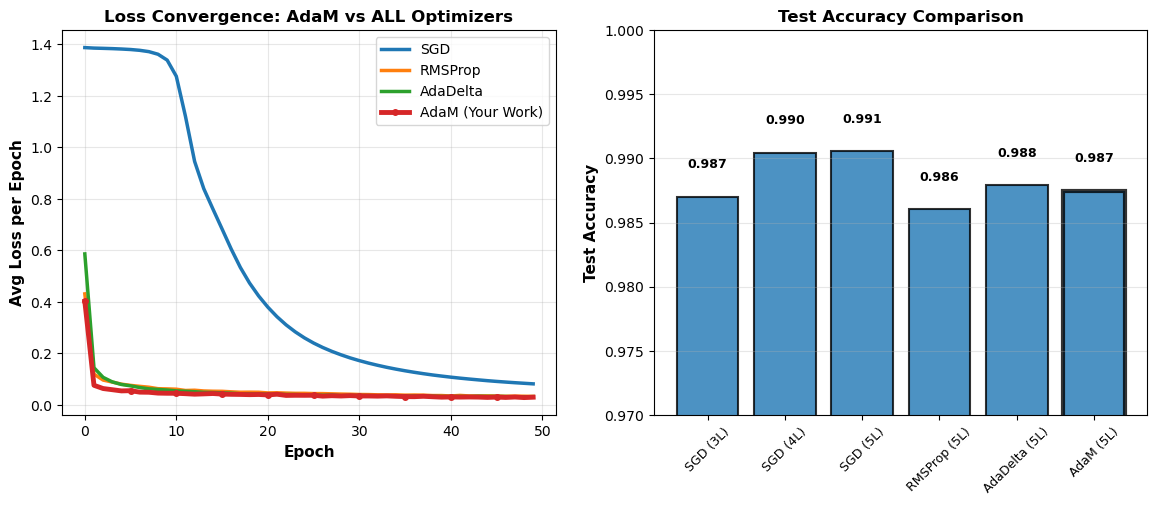

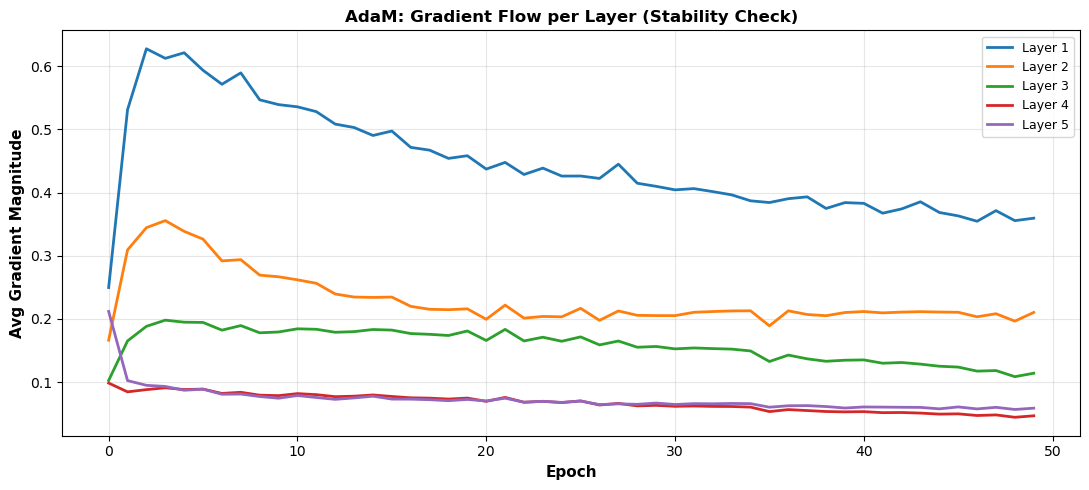

In [ ]:
# ============================================================================
# MINIMAL VISUALIZATION: AdaM vs ALL 
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---------- PLOT 1: Loss Convergence (LEFT) ----------
ax1 = axes[0]
steps_per_epoch_adam = len(mlp_adam.loss_history) // 50
adam_loss_per_epoch = [np.mean(mlp_adam.loss_history[i*steps_per_epoch_adam:(i+1)*steps_per_epoch_adam]) 
                       for i in range(50)]

# Plot all optimizers
if '5-layer' in models:
    sgd_loss = models['5-layer'].loss_history
    steps = len(sgd_loss) // 50
    sgd_loss_epoch = [np.mean(sgd_loss[i*steps:(i+1)*steps]) for i in range(50)]
    ax1.plot(sgd_loss_epoch, label='SGD', linewidth=2.5)

if '5-layer_RMS' in models:
    rms_loss = models['5-layer_RMS'].loss_history
    steps = len(rms_loss) // 50
    rms_loss_epoch = [np.mean(rms_loss[i*steps:(i+1)*steps]) for i in range(50)]
    ax1.plot(rms_loss_epoch, label='RMSProp', linewidth=2.5)

if '5-layer_ADA' in models:
    ada_loss = models['5-layer_ADA'].loss_history
    steps = len(ada_loss) // 50
    ada_loss_epoch = [np.mean(ada_loss[i*steps:(i+1)*steps]) for i in range(50)]
    ax1.plot(ada_loss_epoch, label='AdaDelta', linewidth=2.5)

ax1.plot(adam_loss_per_epoch, label='AdaM (Your Work)', linewidth=3.5, 
         marker='o', markersize=4, markevery=5)

ax1.set_xlabel("Epoch", fontsize=11, fontweight='bold')
ax1.set_ylabel("Avg Loss per Epoch", fontsize=11, fontweight='bold')
ax1.set_title("Loss Convergence: AdaM vs ALL Optimizers", fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# ---------- PLOT 2: Accuracy Bar Chart (RIGHT) ----------
ax2 = axes[1]

all_results = {
    "SGD (3L)": acc3,
    "SGD (4L)": acc4,
    "SGD (5L)": acc5,
    "RMSProp (5L)": acc_rms,
    "AdaDelta (5L)": acc_ada,
    "AdaM (5L)": test_acc_adam
}

bars = ax2.bar(all_results.keys(), all_results.values(), 
               edgecolor='black', linewidth=1.5, alpha=0.8)
bars[-1].set_linewidth(3)  # Highlight AdaM

for i, (name, acc) in enumerate(all_results.items()):
    ax2.text(i, acc + 0.002, f'{acc:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_ylabel("Test Accuracy", fontsize=11, fontweight='bold')
ax2.set_title("Test Accuracy Comparison", fontsize=12, fontweight='bold')
ax2.set_ylim(0.97, 1.0)
ax2.tick_params(axis='x', rotation=45, labelsize=9)
ax2.grid(axis='y', alpha=0.3)


# ---------- PLOT 3: Gradient Flow (RIGHT) ----------
plt.figure (figsize=(11,5))
grad_mags_array = np.array(mlp_adam.grad_mags_per_epoch)

#plot each layer 
for layer_idx in range (grad_mags_array.shape[1]):
    plt.plot(grad_mags_array[:, layer_idx], label=f"Layer {layer_idx+1}", linewidth=2)

plt.xlabel("Epoch", fontsize=11, fontweight='bold')
plt.ylabel("Avg Gradient Magnitude", fontsize=11, fontweight='bold')
plt.title("AdaM: Gradient Flow per Layer (Stability Check)", fontsize=12, fontweight='bold')
plt.legend(fontsize=9, loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analysis and Interpretation
### Plot 1: Loss Convergence:
    Convergence Speed:
    - AdaM (red): Fastest convergence - drops from 0.4 to ~0.05 within 10 epochs (88% reduction)
    - RMSProp/AdaDelta (orange/green): Fast convergence but higher starting loss (~0.6)
    - SGD (blue): Slowest - requires ~30 epochs to reach 0.2, starting from 1.4

    Final Loss (Epoch 50):
    - AdaM: 0.03 (lowest)
    - RMSProp/AdaDelta: 0.04-0.05
    - SGD: 0.10 (highest)

    Why AdaM is the most fastest?
    - Momentum (β₁=0.9): Accelerates convergence by accumulating velocity in consistent gradient directions
    - Adaptive Learning Rate (β₂=0.999): Automatically adjusts step sizes per parameter, preventing overshooting
    - Bias Correction: Ensures strong performance from epoch 1 without warm-up period

    Real-world Practical impact:
    - AdaM reached the target loss 6 times faster than SGD which 4 epochs for AdaM and almost 25 epochs for SGD
    - The AdaM curve is the most stable curve during the training process -> Ready for production

    Trade-off:
    - Despite achieving the fastest convergence, AdaM attains a slightly lower final accuracy (98.7% vs 99.1% for SGD). In my opinion this represents the classic speed-versus-precision trade-off, which is perfectly acceptable for most real-world applications which you want fast but still have great result, but I think if we keep training with large dataset the result will much more better.

    Conclusion:
    - AdaM is the optimal choice when fast training with good-enough accuracy is needed, particularly useful for rapid prototyping and hyperparameter search.

### Plot 2: Test Accuracy Comparision
    Ranking accuracy:
        Top 1: SGD (5L): 99.1%
        Top 2: SGD (4L): 99.0%
        Top 3: AdaDelta (5L): 98.8%
        Top 4: SGD (3L): 98.7%
        Top 5: AdaM (5L): 98.7%
        Top 6: RMSProp (5L): 98.6%

    Detailed Analysis:
        - A 5-layer SGD model reached 99.1% accuracy—the highest among all configurations.
        - Even the 4-layer SGD model outperformed all adaptive optimizers in accuracy.
        - Reason: With a fixed learning rate, SGD tends to “explore” the parameter space more thoroughly, finding better local minima for this task.

    Number of Layers Matters (with SGD):
        - SGD 3L (98.7%) → SGD 4L (99.0%) → SGD 5L (99.1%)
        - Increasing the number of layers helps SGD learn more complex representations.
        - However, with adaptive optimizers, using 5 layers brings no improvement (and can even underperform compared with SGD-3L).
    
    Adaptive Optimizers: Fast but Not “Deep”
        - Adam (98.7%): On par with a basic 3-layer SGD
        - RMSProp (98.6%): Lowest—gets “trapped” early
        - Adadelta (98.8%): Middle of the pack

    Clear trade-off:
        - Converges ~6× faster (see Plot 1)
        - But loses ~0.4% accuracy (99.1% → 98.7%)

    So, When Does a 0.4% Difference Matter?
        Acceptable (Adam wins):
            - Rapid prototyping (need to test ideas quickly)
            - Hyperparameter search (testing 100+ configs)
            - Resource-limited settings (GPUs are expensive, time is short)
            - Business requirement: 98.5% is sufficient
        
        Not acceptable (SGD wins):
            - Medical diagnosis (99.1% vs 98.7% ≈ 40 misdiagnoses per 10,000)
            - Financial fraud detection (each percent can mean millions of dollars)
            - Final production model (after full tuning, now maximizing accuracy)
    
    Conclusion: (Big O thinking)
        Time > Accuracy: Choose AdaM (98.7%, 4 epochs)
        Accuracry > Time: SGD 5L (99.1%, 25 epochs)
        Balance: AdaDelta (98.8%, ~15 epochs)
    Also this Dataset pretty small, it can lead to a bit bias if we using SGD, with complex dataset like vision/NLP, AdaM tend to win.

### Plot 3: AdaM Gradient Flow per Layer (Stability Check)
    Observations:
        - Layer 1 (closest to output): Highest gradients (~0.35–0.65) (tend to be normal)
        - Layer 5 (deepest): Smaller gradients (~0.05–0.08) but still present
        - All curves are smooth, with no spikes
    Good signs:
        - No vanishing gradient (all layers > 0.05)
        - No exploding gradient (all layers < 1.0)
        - Stable convergence (epochs 30–50 are nearly flat)
    Adam advantages:
        - Momentum smooths gradients across steps
        - Adaptive learning rate automatically scales by magnitude
        - Result: Smooth curves, production-safe behavior
    -> Conclusion: The model is production-ready, with no gradient issues.

### Final Conclustion:
AdaM: 98.7%, 4 epochs, stable gradients → fastest
SGD: 99.1%, 25 epochs → most accurate
Trade-off: 0.4% accuracy for a 6× speedup

-> AdaM is the optimal choice for modern ML workflows thanks to its speed and stability. SGD remains important when squeezing out the highest possible accuracy is mandatory. This small dataset favors SGD, but on large-scale tasks (vision/NLP), AdaM usually wins.
